# Qualitative Analysis 1

In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML, Markdown
from lr.text_processing.util import pre_process_nli_df
from collections import Counter
from lr.stats.h_testing import get_paired_t_statistic

## When $\rho=1$ which test examples are affected by the transformation?

In [2]:
m_name = "roberta_large"
data = "snli"
batch = 1
path = "raw_results/{}/{}/syn_p_h/batch{}/rho_1p00_results.csv".format(data, m_name, batch)
df = pd.read_csv(path)

snli_trans = pd.read_csv("data/{}/test_p_h_syn_noun.csv".format(data))
sin_noun = pd.read_csv("data/{}/syn_noun.csv".format(data))
key2id = {k:i for k,i in zip(sin_noun.key,sin_noun.index)}
f = lambda k: key2id[k]

In [3]:
def filter_df_by_label(df, drop_label='-'):
    """
    drop observations with label 'drop_label'
    """
    return df.loc[df.label != drop_label]

In [4]:
snli_ori = pd.read_csv("data/{}/test.csv".format(data))
snli_ori = filter_df_by_label(snli_ori)
pre_process_nli_df(snli_ori)
snli_ori = snli_ori.reset_index(drop=True)

In [5]:
t = get_paired_t_statistic(df)
t

(5.014434202787449, 0.010789902280130293, 9824, 0.21327490211456535)

n = 171 | e_n = 10.4%
0.8830409356725146 [ 0.7791843170377292 , 0.9868975543073001 ]


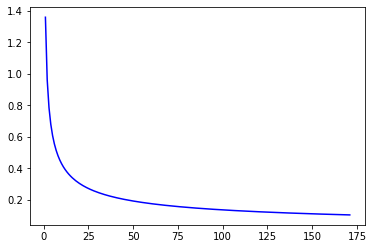

In [6]:
def e(alpha, n):
    return np.sqrt(np.log(2/alpha) / (2*n))

ids = df.loc[(df.A==0) & (df.B==1)]
ids = ids.index.tolist()

b = [701, 1433, 2820, 3114, 3955,
     3970, 4831, 5187,5285, 5664,
     5752, 5811, 6428, 6771, 7424,
    7965, 8151, 8310, 8646, 9786]
select = b[-1]

b_to_print = [5285] 
g = [i for i in ids[:ids.index(select)] if i not in b]
g_to_print = []


more = ids[ids.index(select):]

gn = len(g)
bn = len(b)
pct = gn/(gn+bn)

n = gn+bn 
# n = 200


e95 = lambda n: e(0.05, n)
x = np.array(range(1,n+1))

plt.plot(x, e95(x),color="blue");
p = np.random.uniform(0.5,1)
eps = e95(x)
n = eps.argmin()
e_id = eps[n]


print("n = {} | e_n = {:.1%}".format(x[n], e_id))


print(pct,"[",pct-e_id,",", pct+e_id, "]")

In [7]:
ids = df.loc[(df.A==0) & (df.B==1)]
ids = ids.index.tolist()
n = len(ids)
pct = n/df.shape[0]
display(Markdown(r"### When $\rho=1.0$, the number of disrupted sentences (0 to 1) is {} ({:.1%} of the test data)".format(n,pct)))
comb = pd.concat([snli_ori, snli_trans.add_suffix("_2")],1)
comb = comb.loc[more] 
display(HTML(comb.head(n).to_html()))
# display(HTML(comb.head(2).to_html()))

### When $\rho=1.0$, the number of disrupted sentences (0 to 1) is 171 (1.7% of the test data)

,premise,hypothesis,label,premise_2,hypothesis_2,label_2
9786,a little boy is getting is birthday cake and is blowing out the candles,a child at a party,neutral,a little male child is getting is birthday cake and is blowing out the candles,a kid at a political party,neutral


## What are the most commom transformations that appear on the error pairs?

In [8]:
spaces = re.compile(' +')
results = []

ids = comb.index.tolist()
for id_ in ids:
    s = comb.loc[id_].premise + " " + comb.loc[id_].hypothesis
    st = comb.loc[id_].premise_2 + " " + comb.loc[id_].hypothesis_2
    s = spaces.sub(" ",s)
    st = spaces.sub(" ",st)
    s = s.strip()
    st = st.strip()
    s = set(s.split(" "))
    st = set(st.split(" "))
    diff = list(s - st)
    try:
        diff = list(map(f, diff))
        results += diff
    except KeyError:
        print(id_)
        print(s)
        print(st)
    
    
    
results_c = Counter(results)
dict_id = [i[0] for i in results_c.most_common(10)]
sin_noun.loc[:, "freq"] = [results_c[i]/len(results) for i in sin_noun.index]
sin_noun = sin_noun.sort_values("freq", ascending=False)
sin_noun.loc[:, "freq"] = sin_noun.freq.map(lambda x: "{:.1%}".format(x))
sin_noun.head(10)

,key,value,freq
637,boy,male child,100.0%
0,11th,eleventh,0.0%
4158,plug,stopper,0.0%
4167,pod,cod,0.0%
4166,pm,autopsy,0.0%
4165,plywood,plyboard,0.0%
4164,plutonium,pu,0.0%
4163,plunges,dip,0.0%
4162,plunger,speculator,0.0%
4161,plunge,dip,0.0%
